In [1]:
from fireTS.models import NARX, DirectAutoRegressor
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_squared_error

C:\Users\mitsy\OneDrive\Documentos\anacon\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Nonlinear AutoRegression with eXogenous (NARX) model
fireTS.models.NARX model is trying to train a one-step-ahead-prediction model and make multi-step prediction recursively given the future exogenous inputs.

https://pypi.org/project/fireTS/

In [2]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from scipy.signal import savgol_filter
import math
import sklearn
from random import *
import csv
import pandas as pd
import datetime
import time

In [3]:
#read the data into list
dt=2
path = 'csv files with data/04-trial5.csv'
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    time = [row[0] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    f1 = [row[1] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    f2 = [row[2] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    t1 = [row[3] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    h1 = [row[4] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    t2 = [row[5] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    h2 = [row[6] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    t3 = [row[7] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    h4 = [row[8] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    af = [row[9] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    t4 = [row[10] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    wm = [row[11] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    t5 = [row[12] for row in reader]
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    h3 = [row[13] for row in reader]

In [4]:
filter_len = 65
filter_order = 3
del time[0]
time = list(map(int,time))
del f1[0]
f1 = list(map(float,f1))
del f2[0]
f2 = list(map(float,f2))
del t1[0]
t1 = list(map(float,t1))
del h1[0]
h1 = list(map(float,h1))
del t2[0]
t2 = list(map(float,t2))
del h2[0]
h2 = list(map(float,h2))
del t3[0]
t3 = list(map(float,t3))
t3 = savgol_filter(t3,filter_len,filter_order)  # smoothing filter of fourth order
del h4[0]
h4 = list(map(float,h4))
del af[0]
af = list(map(float,af))
af = savgol_filter(af,filter_len,filter_order)  # smoothing filter of fourth order
del t4[0]
t4 = list(map(float,t4))
del wm[0]
wm = list(map(float,wm))
del t5[0]
t5 = list(map(float,t5))
del h3[0]
h3 = list(map(float,h3))
h3 = savgol_filter(h3,filter_len,filter_order)  # smoothing filter of fourth order
er=np.empty((len(t5)))

for i in range(1,len(h3),1): #evaporation rate, in ml/h. This is the Y value that we want to fit and predict
    # evaporation rate must be calculated to amount of water leaving the towel
    # for that the measurement h3 is calibrated to weight of water
    er[i] = (h3[i]-h3[i-1])/dt  # evaporation rate is the difference between two timestamps
er[0] = er[1]

In [5]:
X = list(zip(t1, h1, t2, h2, t3, h4, af, t4, t5, h3))
# X = list(zip(t1, h1, t3, h4, af, t4, t5, h3))
Y = er

In [6]:
x=np.array(X)
y=np.array(Y)

# Build a non-linear autoregression model with exogenous inputs
# using Random Forest regression as the base model
mdl1 = NARX(
    RandomForestRegressor(n_estimators=10),
    auto_order=2,
    exog_order=[1,1,1,1,1,1,1,1,1,1],
    exog_delay=[1,1,1,1,1,1,1,1,1,1])
mdl1.fit(x, y)
ypred1 = mdl1.predict(x, y, step=3)

In [7]:
#deleting nan values
for i in range(4):
         ypred1[i]=0
         y[i]=0

In [8]:
mean_squared_error(y,ypred1)

2.0860415174307345e-05

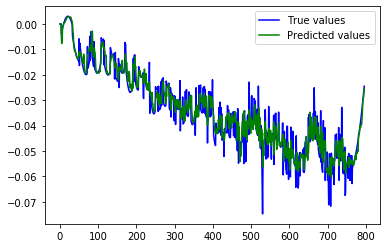

In [9]:
plt.plot(y,'b', label = 'True values')
plt.plot(ypred1,'g', label = 'Predicted values')
plt.legend()
plt.show()

In [13]:
h3_sim = np.zeros(len(h3))
h3_sim[0] = h3[0] # same initial condition
for i in range(1,len(h3),1):
    condition = np.atleast_2d(np.array(list((t1[i], h1[i], t2[i], h2[i], t3[i], h4[i], af[i], t4[i], t5[i], h3_sim[i]))))
#     condition = np.atleast_2d(np.array(list((t1[i], h1[i], t3[i], h4[i], af[i], t4[i], t5[i], h3_sim[i]))))
    predicted = mdl1.predict(condition,er[i],step=3)
    h3_sim[i] = h3_sim[i-1] + predicted*dt # integration step
    if h3_sim[i] < 10: break

# Plot
fig, ax = plt.subplots(1,1,figsize=(16,9))
ax.set_title('Water content, real vs simulated')
ax.plot(h3, label = "Real")
ax.plot(h3_sim, label = "Simulated")
ax.legend()
ax.set_xlabel('cycles, n'), ax.grid(linestyle='--',linewidth='0.4', color='black')
plt.subplots_adjust(hspace = 0.3, wspace = 0.1)
plt.show()

ValueError: bad input shape ()